In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# Azure Credentials
subscription_key = os.getenv("AZURE_SUBSCRIPTION_KEY")
endpoint = os.getenv("AZURE_AI_SERVICE_ENDPOINT")

# OpenAI Credentials
api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key= os.getenv("AZURE_OPENAI_API_KEY")
deployment_name = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")

# Pre-requisites (uncomment to pip install if not using the venv. to setup the venv, see readme)
# !pip install azure-cognitiveservices-vision-computervision matplotlib pillow openai

# use a .ttf font that can support all languages you want to translate to
# e.g. use https://github.com/notofonts/noto-cjk/tree/main/Sans
FONT_PATH = "./NotoSans-Medium.ttf"

# Testing with ComputerVisionClient

Operation Location: https://yazan-imageread.cognitiveservices.azure.com/vision/v3.2/read/analyzeResults/ee9a9b92-2e50-4c4e-8e6a-c95c79cc3180
Operation ID: ee9a9b92-2e50-4c4e-8e6a-c95c79cc3180
Status: OperationStatusCodes.running
Status: OperationStatusCodes.succeeded
{'text': 'LIFE', 'bounding_box': [42.0, 115.0, 335.0, 103.0, 337.0, 171.0, 43.0, 184.0], 'confidence': 0.945}
{'text': 'IS LIKE', 'bounding_box': [437.0, 97.0, 960.0, 80.0, 964.0, 145.0, 440.0, 169.0], 'confidence': 0.972}
{'text': 'RIDING', 'bounding_box': [212.0, 233.0, 519.0, 223.0, 521.0, 271.0, 213.0, 280.0], 'confidence': 0.972}
{'text': 'A BICYCLE', 'bounding_box': [582.0, 220.0, 1035.0, 205.0, 1036.0, 251.0, 583.0, 268.0], 'confidence': 0.972}
{'text': 'TO', 'bounding_box': [116.0, 372.0, 243.0, 373.0, 243.0, 427.0, 118.0, 429.0], 'confidence': 0.915}
{'text': 'KEEP', 'bounding_box': [243.0, 366.0, 484.0, 354.0, 487.0, 409.0, 243.0, 424.0], 'confidence': 0.945}
{'text': 'YOUR BALANCE', 'bounding_box': [529.0, 354.0

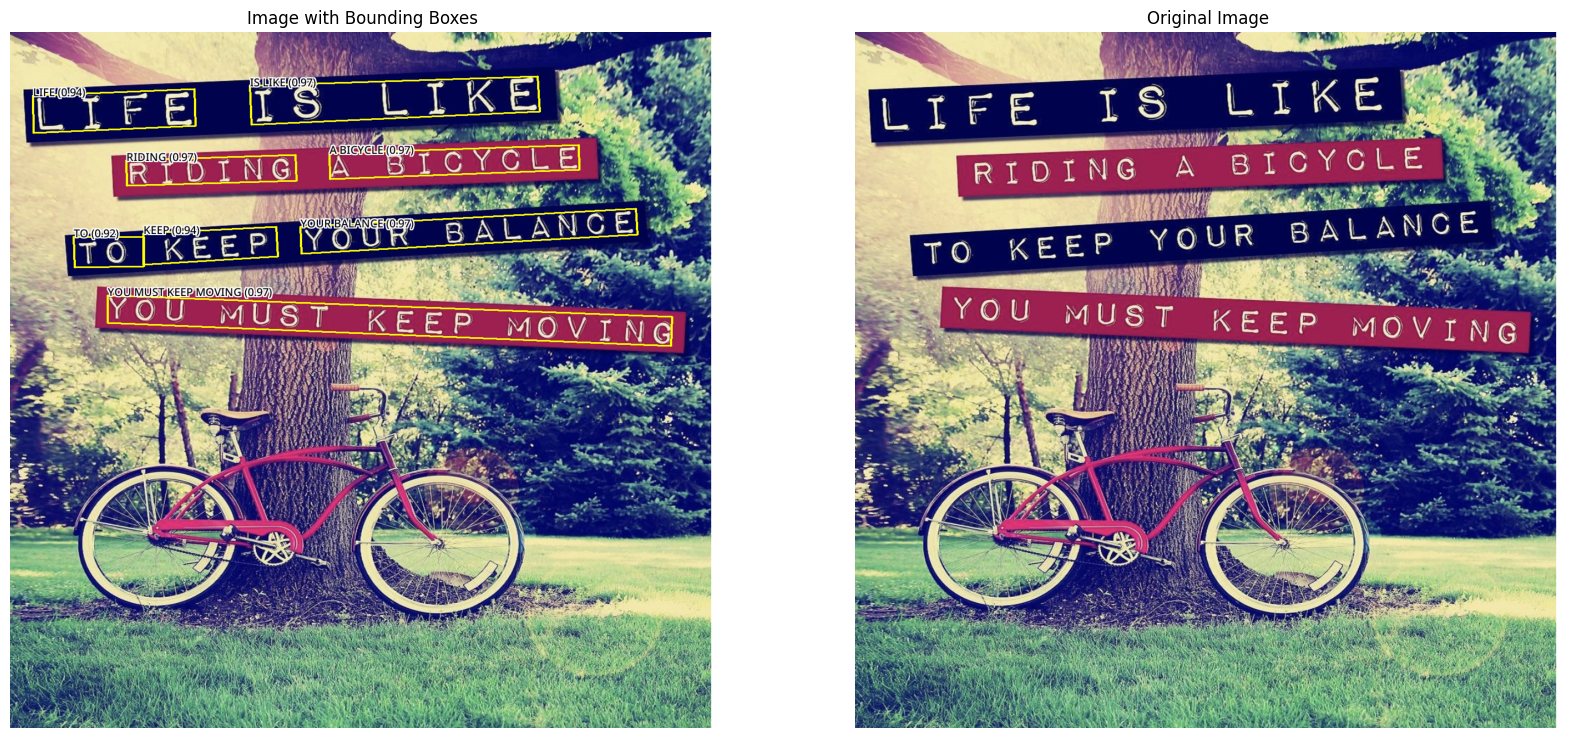

In [4]:
# Importing necessary libraries
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import json

# Initialize Computer Vision Client
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))


image_path = "./images/bicycle.png"

with open(image_path, "rb") as image_stream:
    ocr_result = computervision_client.read_in_stream(image_stream, raw=True)

operation_location = ocr_result.headers["Operation-Location"]
print(f"Operation Location: {operation_location}")

operation_id = operation_location.split("/")[-1]
print(f"Operation ID: {operation_id}")

while True:
    result = computervision_client.get_read_result(operation_id)
    print(f"Status: {result.status}")
    if result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

if result.status == OperationStatusCodes.succeeded:
    read_results = result.analyze_result.read_results
    line_bounding_boxes = []
    if read_results:
        for read_result in read_results:
            for line in read_result.lines:
                line_bounding_boxes.append({
                    "text": line.text,
                    "bounding_box": line.bounding_box,
                    "confidence": line.appearance.style.confidence if line.appearance else None
                })
        line_bounding_boxes
    else:
        raise Exception("No text was recognized in the image.")
else:
    raise Exception("OCR operation did not succeed.")

image = Image.open(image_path)
draw = ImageDraw.Draw(image)
font_size = 20
font = ImageFont.truetype(FONT_PATH, font_size)
    

for line_info in line_bounding_boxes:
    print(line_info)
    bounding_box = line_info['bounding_box']
    confidence = line_info['confidence']
    pts = [(bounding_box[i], bounding_box[i+1]) for i in range(0, len(bounding_box), 2)]
    

    # Draw thicker polygon for bounding box with width parameter
    draw.line(pts + [pts[0]], fill="yellow", width=4)
    
    # Coordinates for the text
    x, y = bounding_box[0], bounding_box[1] - font_size

    # Draw white text outline
    outline_range = 2
    for dx in range(-outline_range, outline_range + 1):
        for dy in range(-outline_range, outline_range + 1):
            if dx != 0 or dy != 0:
                draw.text((x + dx, y + dy), f"{line_info['text']} ({confidence:.2f})", font=font, fill="white")

    # Draw black text
    draw.text((x, y), f"{line_info['text']} ({confidence:.2f})", font=font, fill="black")    

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.array(image))
plt.title("Image with Bounding Boxes")
plt.axis("off")

original_image = Image.open(image_path)
plt.subplot(1, 2, 2)
plt.imshow(np.array(original_image))
plt.title("Original Image")
plt.axis("off")

plt.show()


Note how ComputerVision client works, but the the detection seems to be quite fragmented, and line detection is not good. Let's try the other alternative, ImageAnalysis.

# ImageAnalysisClient

{'text': 'LIFE IS LIKE', 'bounding_box': [41, 111, 963, 77, 966, 147, 41, 185], 'confidence': 0.988}
{'text': 'RIDING A BICYCLE', 'bounding_box': [210, 231, 1035, 204, 1037, 254, 212, 281], 'confidence': 0.993}
{'text': 'TO', 'bounding_box': [120, 377, 219, 373, 220, 422, 121, 426], 'confidence': 0.954}
{'text': 'KEEP YOUR BALANCE', 'bounding_box': [244, 365, 1136, 318, 1139, 373, 247, 423], 'confidence': 0.989}
{'text': 'YOU MUST KEEP MOVING', 'bounding_box': [171, 473, 1211, 516, 1208, 573, 168, 531], 'confidence': 0.998}


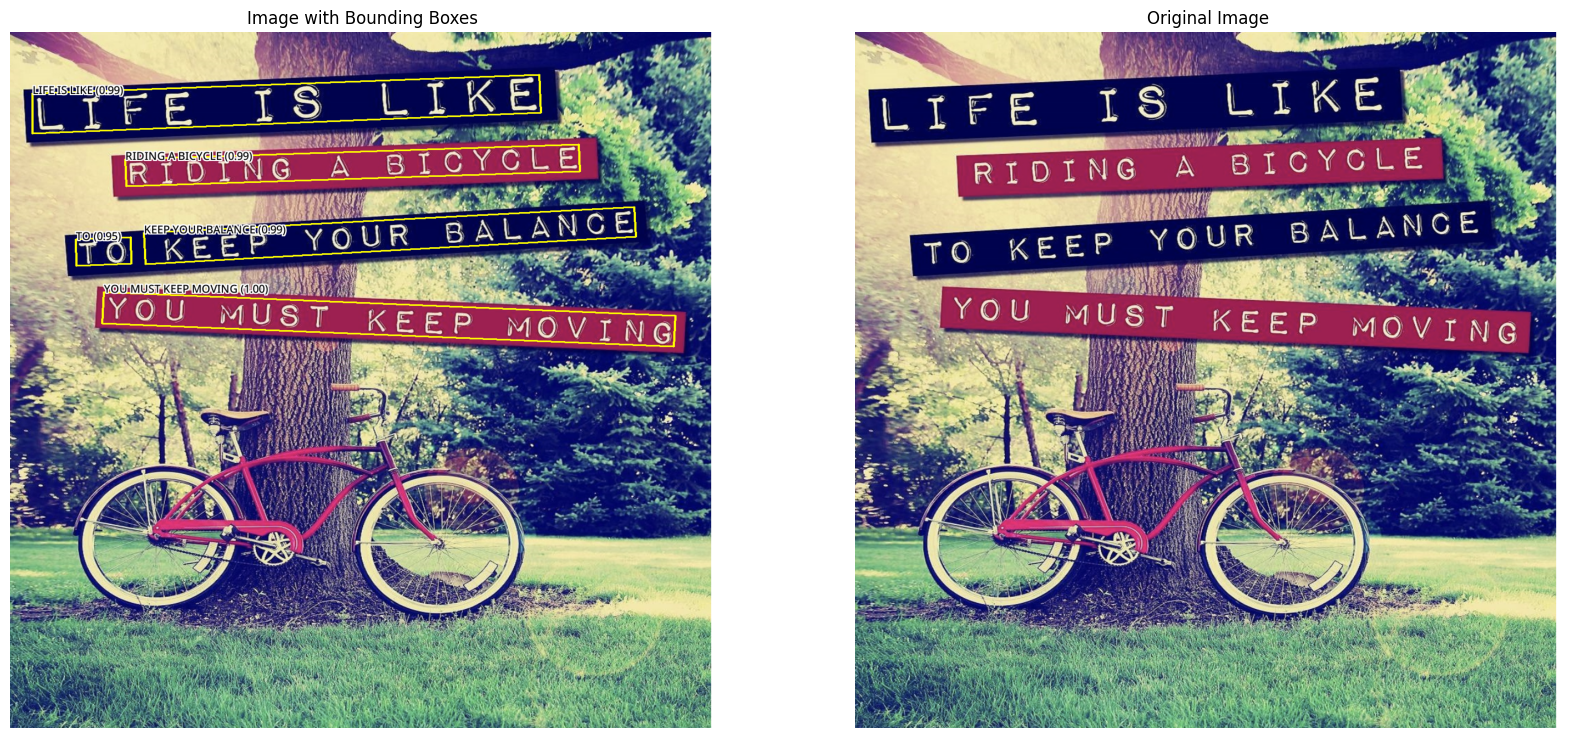

In [5]:
# Initialize Image Analysis Client
image_analysis_client = ImageAnalysisClient(endpoint, AzureKeyCredential(subscription_key))

image_path = "./images/bicycle.png"

with open(image_path, "rb") as image_stream:
    image_data = image_stream.read()
    result = image_analysis_client.analyze(
        image_data=image_data,
        visual_features=[VisualFeatures.READ],
    )

if result.read is not None:
    line_bounding_boxes = []
    for line in result.read.blocks[0].lines:
        bounding_box = []
        for point in line.bounding_polygon:
            bounding_box.append(point.x)
            bounding_box.append(point.y)
        line_bounding_boxes.append({
            "text": line.text,
            "bounding_box": bounding_box,
            "confidence": line.words[0].confidence if line.words else None
        })
else:
    raise Exception("No text was recognized in the image.")


image = Image.open(image_path)
draw = ImageDraw.Draw(image)
font_size = 20
font = ImageFont.truetype(FONT_PATH, font_size)
    

for line_info in line_bounding_boxes:
    print(line_info)
    bounding_box = line_info['bounding_box']
    confidence = line_info['confidence']
    pts = [(bounding_box[i], bounding_box[i+1]) for i in range(0, len(bounding_box), 2)]
    

    # Draw thicker polygon for bounding box with width parameter
    draw.line(pts + [pts[0]], fill="yellow", width=4)
    
    # Coordinates for the text
    x, y = bounding_box[0], bounding_box[1] - font_size

    # Draw white text outline
    outline_range = 2
    for dx in range(-outline_range, outline_range + 1):
        for dy in range(-outline_range, outline_range + 1):
            if dx != 0 or dy != 0:
                draw.text((x + dx, y + dy), f"{line_info['text']} ({confidence:.2f})", font=font, fill="white")

    # Draw black text
    draw.text((x, y), f"{line_info['text']} ({confidence:.2f})", font=font, fill="black")    

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.array(image))
plt.title("Image with Bounding Boxes")
plt.axis("off")

original_image = Image.open(image_path)
plt.subplot(1, 2, 2)
plt.imshow(np.array(original_image))
plt.title("Original Image")
plt.axis("off")

plt.show()


Now we see improvement in line detection.

# Defining Functions for Image Analysis via Azure's API
- We define functions to use the image analysis API
- We also save bounding boxes and text data to a json

In [13]:
# Importing necessary libraries
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import json

# Initialize Image Analysis Client
image_analysis_client = ImageAnalysisClient(endpoint, AzureKeyCredential(subscription_key))

# Function to Get Line Bounding Boxes
def get_line_bounding_boxes(image_path):
    with open(image_path, "rb") as image_stream:
        image_data = image_stream.read()
        result = image_analysis_client.analyze(
            image_data=image_data,
            visual_features=[VisualFeatures.READ],
        )

    if result.read is not None:
        line_bounding_boxes = []
        for line in result.read.blocks[0].lines:
            bounding_box = []
            for point in line.bounding_polygon:
                bounding_box.append(point.x)
                bounding_box.append(point.y)
            line_bounding_boxes.append({
                "text": line.text,
                "bounding_box": bounding_box,
                "confidence": line.words[0].confidence if line.words else None
            })
        return line_bounding_boxes
    else:
        raise Exception("No text was recognized in the image.")

# Function to Save Bounding Boxes and Confidence Scores as JSON
def save_bounding_boxes(image_path, bounding_boxes):
    base_name = os.path.basename(image_path)
    name, _ = os.path.splitext(base_name)
    output_dir = "./bounding_boxes"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{name}.json")
    
    with open(output_path, "w", encoding="utf-8") as json_file:
        json.dump(bounding_boxes, json_file, ensure_ascii=False, indent=4)

# Function to Load Bounding Boxes and Confidence Scores from JSON
def load_bounding_boxes(json_path):
    with open(json_path, "r", encoding="utf-8") as json_file:
        return json.load(json_file)



# Function to Plot Bounding Boxes on Image. Set display=True to display the image in a notebook.
# Saves images to ./analyzed_images
def plot_bounding_boxes(image_path, line_bounding_boxes, display=True):
    # Create output directory if it doesn't exist
    os.makedirs('./analyzed_images', exist_ok=True)
    
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    font_size = 20

    font = ImageFont.truetype(FONT_PATH, font_size)
    
    for line_info in line_bounding_boxes:
        print(line_info)
        bounding_box = line_info['bounding_box']
        confidence = line_info['confidence']
        pts = [(bounding_box[i], bounding_box[i+1]) for i in range(0, len(bounding_box), 2)]
        
        # Draw thicker polygon for bounding box with width parameter
        draw.line(pts + [pts[0]], fill="yellow", width=4)
        
        # Coordinates for the text
        x, y = bounding_box[0], bounding_box[1] - font_size

        # Draw white text outline
        outline_range = 2
        for dx in range(-outline_range, outline_range + 1):
            for dy in range(-outline_range, outline_range + 1):
                if dx != 0 or dy != 0:
                    draw.text((x + dx, y + dy), f"{line_info['text']} ({confidence:.2f})", font=font, fill="white")

        # Draw black text
        draw.text((x, y), f"{line_info['text']} ({confidence:.2f})", font=font, fill="black")
    
    # Save the annotated image
    output_path = os.path.join('./analyzed_images', os.path.basename(image_path))
    image.save(output_path)
    
    if display:
        # Display the image
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image))
        plt.title("Image with Bounding Boxes")
        plt.axis("off")
        
        original_image = Image.open(image_path)
        plt.subplot(1, 2, 2)
        plt.imshow(np.array(original_image))
        plt.title("Original Image")
        plt.axis("off")
        
        plt.show()

# High-level function to process an image given a list of image paths
def process_image_paths(image_paths):
    output_dir = "./bounding_boxes"
    os.makedirs(output_dir, exist_ok=True)

    for image_path in image_paths:
        if image_path.endswith((".png", ".jpg", ".jpeg")):
            print(f"Processing {image_path}")
            line_bounding_boxes = get_line_bounding_boxes(image_path)
            if line_bounding_boxes:
                save_bounding_boxes(image_path, line_bounding_boxes)
                plot_bounding_boxes(image_path, line_bounding_boxes, display=True)

            

# Turning Detected Text into Translation Prompts
- Now that we have successfully extracted the data from the image, we need it to be translated.
- We thus generate a prompt that contains the translated text line-by-line.
- We ask a LLM to translate the text

In [23]:
def retrieve_bounding_boxes_by_image_path(image_path):
    image_name = os.path.basename(image_path).split(".")[0]
    json_path = f"./bounding_boxes/{image_name}.json"
    if os.path.exists(json_path):
        bounding_boxes = load_bounding_boxes(json_path)
        if os.path.exists(image_path):
            return bounding_boxes
        else:
            print(f"Image file {image_path} does not exist.")
    else:
        print(f"Bounding box data {json_path} does not exist.")

def extract_text_from_image_path(image_path):
    image_name = os.path.basename(image_path).split(".")[0]
    json_path = f"./bounding_boxes/{image_name}.json"
    if os.path.exists(json_path):
        bounding_boxes = load_bounding_boxes(json_path)
        if not os.path.exists(image_path):
            raise Exception(f"Image file {image_path} does not exist.")
    else:
        print(f"Bounding box data {json_path} does not exist. Generating..." )
        bounding_boxes = get_line_bounding_boxes(image_path)
        if bounding_boxes:
            save_bounding_boxes(image_path, bounding_boxes)
        else:
            raise Exception("No text was recognized in the image.")

    data = list()
    for bounding_box in bounding_boxes:
        data.append((bounding_box["text"]))
        

    return data

def gen_image_translation_prompt(image_path, language):
    text_data = extract_text_from_image_path(image_path)
    prompt =\
f'''
You are a translator that receives a batch of lines in an image . Given the following yaml file, please translate each line into {language}. 
For each line, fill it in with the translation, respecting the context of the text.
Return only the yaml file, fully filled in.
'''
    
    for line in text_data:
        prompt += f"- {line}\n"
    return prompt


# Using Functions

Processing ./images/bicycle.png
{'text': 'LIFE IS LIKE', 'bounding_box': [41, 111, 963, 77, 966, 147, 41, 185], 'confidence': 0.988}
{'text': 'RIDING A BICYCLE', 'bounding_box': [210, 231, 1035, 204, 1037, 254, 212, 281], 'confidence': 0.993}
{'text': 'TO', 'bounding_box': [120, 377, 219, 373, 220, 422, 121, 426], 'confidence': 0.954}
{'text': 'KEEP YOUR BALANCE', 'bounding_box': [244, 365, 1136, 318, 1139, 373, 247, 423], 'confidence': 0.989}
{'text': 'YOU MUST KEEP MOVING', 'bounding_box': [171, 473, 1211, 516, 1208, 573, 168, 531], 'confidence': 0.998}


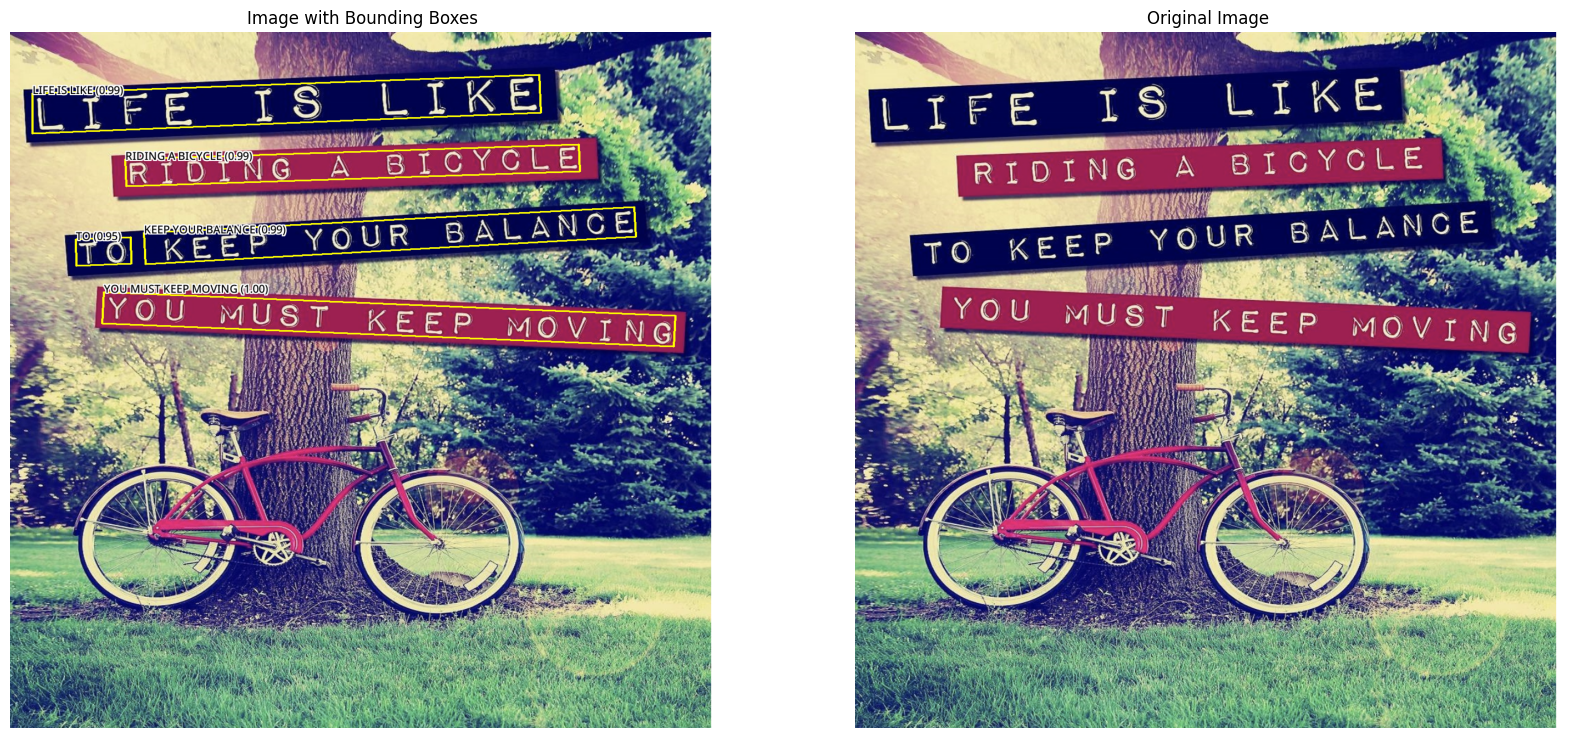

In [ ]:
image_path = "./images/bicycle.png"                
process_image_paths([image_path])

In [16]:
bbox_data = retrieve_bounding_boxes_by_image_path("./images/bicycle.png")
print(bbox_data)
print()

print(extract_text_from_image_path("./images/bicycle.png"))
print()

print(gen_image_translation_prompt("./images/bicycle.png", "spanish"))

[{'text': 'LIFE IS LIKE', 'bounding_box': [41, 111, 963, 77, 966, 147, 41, 185], 'confidence': 0.988}, {'text': 'RIDING A BICYCLE', 'bounding_box': [210, 231, 1035, 204, 1037, 254, 212, 281], 'confidence': 0.993}, {'text': 'TO', 'bounding_box': [120, 377, 219, 373, 220, 422, 121, 426], 'confidence': 0.954}, {'text': 'KEEP YOUR BALANCE', 'bounding_box': [244, 365, 1136, 318, 1139, 373, 247, 423], 'confidence': 0.989}, {'text': 'YOU MUST KEEP MOVING', 'bounding_box': [171, 473, 1211, 516, 1208, 573, 168, 531], 'confidence': 0.998}]

['LIFE IS LIKE', 'RIDING A BICYCLE', 'TO', 'KEEP YOUR BALANCE', 'YOU MUST KEEP MOVING']


You are a translator that receives a batch of lines in an image . Given the following yaml file, please translate each line into spanish. 
For each line, fill it in with the translation, respecting the context of the text.
Return only the yaml file, fully filled in.
- LIFE IS LIKE
- RIDING A BICYCLE
- TO
- KEEP YOUR BALANCE
- YOU MUST KEEP MOVING



# Trying OpenAI Translation
- GPT4o is used to translate the text

In [19]:
from openai import AzureOpenAI
import re

client = AzureOpenAI(
    api_key=api_key,  
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}"
)
response = client.chat.completions.create(
    model=deployment_name,
    messages=[
        { "role": "system", "content": "You are a helpful assistant." },
        { "role": "user", "content": [  
            { 
                "type": "text", 
                "text": gen_image_translation_prompt("./images/bicycle.png", "spanish")
            },
        ] } 
    ],
    max_tokens=2000 
)

print(response.choices[0].message.content)

```yaml
- LA VIDA ES COMO
- ANDAR EN BICICLETA
- PARA
- MANTENER EL EQUILIBRIO
- DEBES SEGUIR MOVIÉNDOTE
```


GPT4o respects the output notation– we only get a code block with the translation. We then have to remove the markdown code block, and extract out the yaml lines.

In [20]:

def remove_code_backticks(message):
    match = re.match(r'```(?:\w+)?\n(.*?)\n```', message, re.DOTALL)
    return match.group(1) if match else message

def extract_yaml_lines(message):
    lines = message.split('\n')
    yaml_lines = [line[2:] for line in lines if line.startswith('- ')]
    return yaml_lines

def get_translated_text_data(image_path, language):
    prompt = gen_image_translation_prompt(image_path, language)
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            { "role": "system", "content": "You are a helpful assistant." },
            { "role": "user", "content": [  
                { 
                    "type": "text", 
                    "text": prompt
                },
            ] } 
        ],
        max_tokens=2000 
    )
    res = extract_yaml_lines(remove_code_backticks(response.choices[0].message.content))
    print(f"Prompt: {prompt}")
    print(f"Response: {res}")
    return res



In [21]:
print(remove_code_backticks(response.choices[0].message.content))
print(extract_yaml_lines(remove_code_backticks(response.choices[0].message.content)))

- LA VIDA ES COMO
- ANDAR EN BICICLETA
- PARA
- MANTENER EL EQUILIBRIO
- DEBES SEGUIR MOVIÉNDOTE
['LA VIDA ES COMO', 'ANDAR EN BICICLETA', 'PARA', 'MANTENER EL EQUILIBRIO', 'DEBES SEGUIR MOVIÉNDOTE']


# Drawing Translated Text
- We draw the translated text on the image
- We warp it to fit the bounding boxes of the original text
- We also set the colour to follow the average colour of the bounding box


Prompt: 
You are a translator that receives a batch of lines in an image . Given the following yaml file, please translate each line into Spanish. 
For each line, fill it in with the translation, respecting the context of the text.
Return only the yaml file, fully filled in.
- LIFE IS LIKE
- RIDING A BICYCLE
- TO
- KEEP YOUR BALANCE
- YOU MUST KEEP MOVING

Response: ['LA VIDA ES COMO', 'ANDAR EN BICICLETA', 'PARA', 'MANTENER EL EQUILIBRIO', 'DEBES SEGUIR MOVIÉNDOTE']


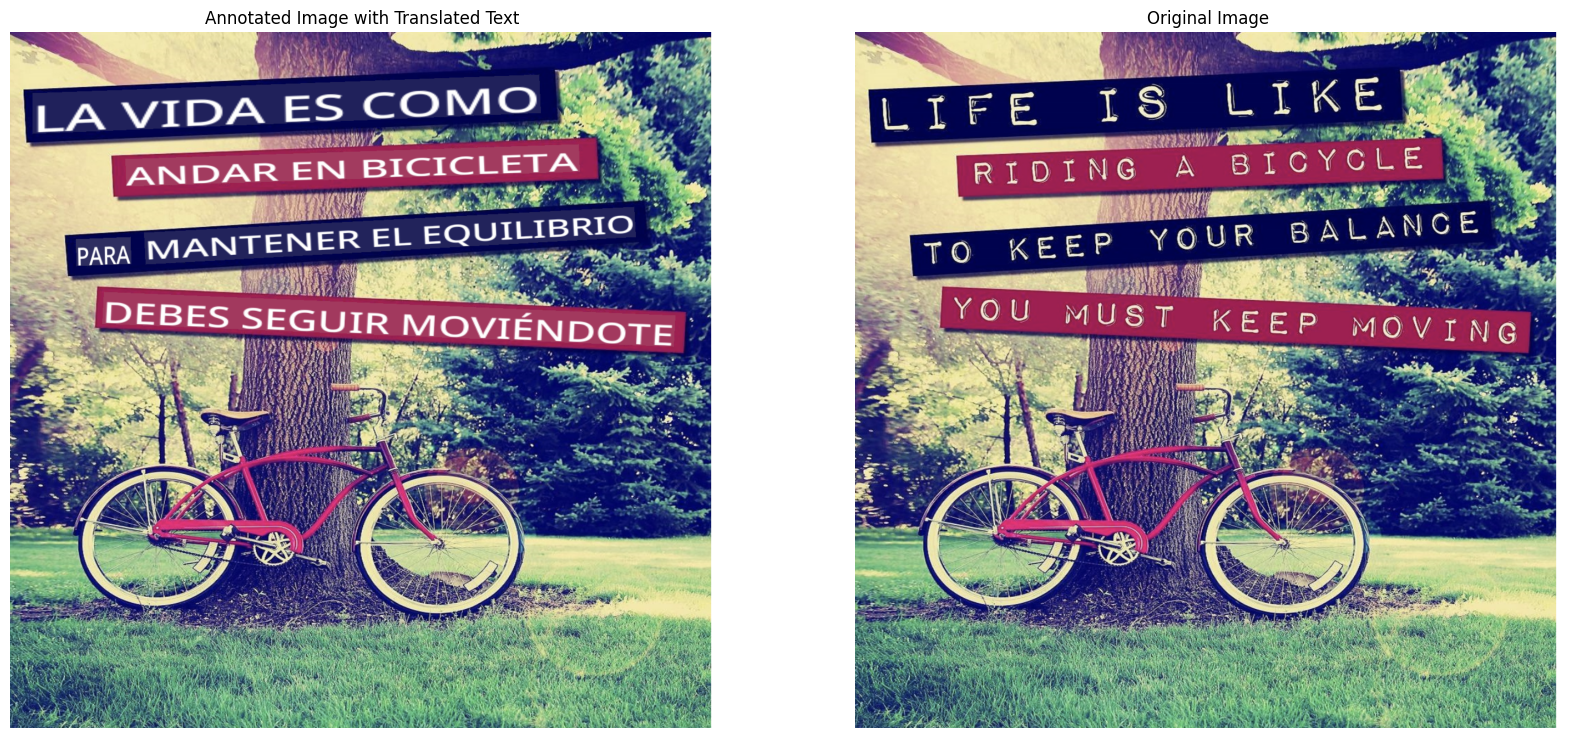

In [24]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageStat


# Function to get the average color of a bounding box area
def get_average_color(image, bounding_box):
    mask = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(mask)
    pts = [(bounding_box[i], bounding_box[i+1]) for i in range(0, len(bounding_box), 2)]
    draw.polygon(pts, fill=255)
    stat = ImageStat.Stat(image, mask)
    avg_color = tuple(int(x) for x in stat.mean[:3])  # Ensure it's a tuple of ints
    return avg_color

# Function to determine the grayscale color for text
def get_text_color(bg_color):
    # Using luminance formula to determine if the text should be black or white
    luminance = (0.299*bg_color[0] + 0.587*bg_color[1] + 0.114*bg_color[2])/255
    return (0, 0, 0) if luminance > 0.5 else (255, 255, 255)

# Function to apply perspective warp to text image
def warp_image_to_bounding_box(image, bounding_box, image_width, image_height):
    h, w = image.shape[:2]
    src_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    dst_pts = np.float32([(bounding_box[i], bounding_box[i+1]) for i in range(0, len(bounding_box), 2)])
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(image, matrix, (image_width, image_height))
    return warped

# Function to draw text onto an image
def draw_text_on_image(text, font, text_color):
    # Create an image with transparent background
    size = font.getbbox(text)[2:]  # width and height of the text
    text_image = Image.new('RGBA', size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(text_image)
    draw.text((0, 0), text, font=font, fill=text_color)
    return text_image

# Function to create a filled polygon mask
def create_filled_polygon_mask(bounding_box, image_size, fill_color):
    mask_image = Image.new('RGBA', image_size, (255, 255, 255, 0))
    mask_draw = ImageDraw.Draw(mask_image)
    pts = [(bounding_box[i], bounding_box[i+1]) for i in range(0, len(bounding_box), 2)]
    mask_draw.polygon(pts, fill=fill_color)
    return mask_image

# Function to Plot Annotated Image
def plot_annotated_image(image_path, line_bounding_boxes, translated_text_list):
    # Create output directory if it doesn't exist
    os.makedirs('./translated_images', exist_ok=True)
    
    image = Image.open(image_path).convert('RGBA')
    
    font_size = 40
    font = ImageFont.truetype(FONT_PATH, font_size)
    
    for line_info, translated_text in zip(line_bounding_boxes, translated_text_list):
        bounding_box = line_info['bounding_box']

        # Get the average color of the bounding box area
        bg_color = get_average_color(image, bounding_box)
        text_color = get_text_color(bg_color)

        # Create a mask to fill the bounding box area with the background color
        mask_image = create_filled_polygon_mask(bounding_box, image.size, bg_color)
        
        # Composite the mask onto the image to fill the bounding box
        image = Image.alpha_composite(image, mask_image)
        
        # Draw the translated text onto a temporary image
        text_image = draw_text_on_image(translated_text, font, text_color)
        
        # Convert the text image to an array and warp it to fit the bounding box
        text_image_array = np.array(text_image)
        warped_text_image = warp_image_to_bounding_box(text_image_array, bounding_box, image.width, image.height)
        
        # Convert the warped text image back to PIL format and paste it onto the original image
        warped_text_image_pil = Image.fromarray(warped_text_image)
        image = Image.alpha_composite(image, warped_text_image_pil)
    
    # Save the annotated image
    output_path = os.path.join('./translated_images', os.path.basename(image_path))
    image.save(output_path)
    
    # Display the image
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image.convert('RGB'))
    plt.title("Annotated Image with Translated Text")
    plt.axis("off")
    
    original_image = Image.open(image_path)
    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.show()

    
imagepath = "./images/bicycle.png"
plot_annotated_image(imagepath, retrieve_bounding_boxes_by_image_path(imagepath), get_translated_text_data(imagepath, "Spanish"))

# High Level Function


Prompt: 
You are a translator that receives a batch of lines in an image . Given the following yaml file, please translate each line into English. 
For each line, fill it in with the translation, respecting the context of the text.
Return only the yaml file, fully filled in.
- 내일은 더 강해지기를.

Response: ['May you be stronger tomorrow.']


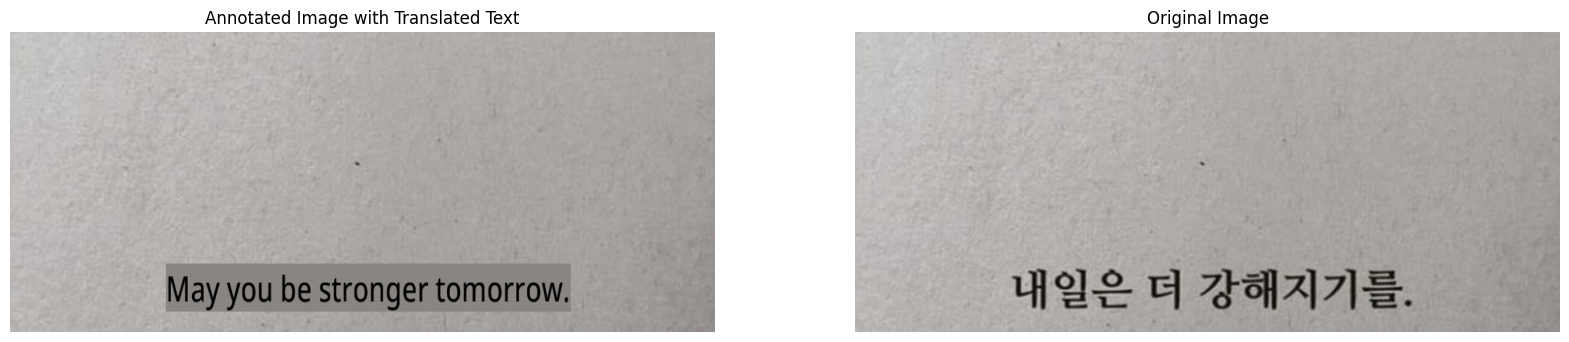

Prompt: 
You are a translator that receives a batch of lines in an image . Given the following yaml file, please translate each line into Malay. 
For each line, fill it in with the translation, respecting the context of the text.
Return only the yaml file, fully filled in.
- Introduction to
- Programming
- Tools
- Editors ..
- . where you write
- Tools
- code + debug .
- you may run the
- code too !
- mi
- interpreter
- e.g. Vscode
- a = 'hi!
- b= 'yo'
- 00
- Atom
- C = 10
- Program
- 10 =
- Result
- Browsers ...
- Ada Lovelace
- written w/ Code
- . run your code on web
- Languages
- - view visual elements
- Javascript
- · use DevTools to inspect + debug
- JS
- e.g.
- Edge, Chrome, Firefox
- @ girlie _mac
- @ azure advocates
- High-level
- if(i=j)
- programming
- f=g+h;
- Command Line Tools ..
- DOCS ...
- else
- ython 1 , 1 }
- language
- f=g-h;
- Low - level
- V
- Ruby
- >
- send commands
- ( lines of text ) to
- . where you
- programming
- beg $3, $4, True
- learn
- Sub $0, $$1, $2


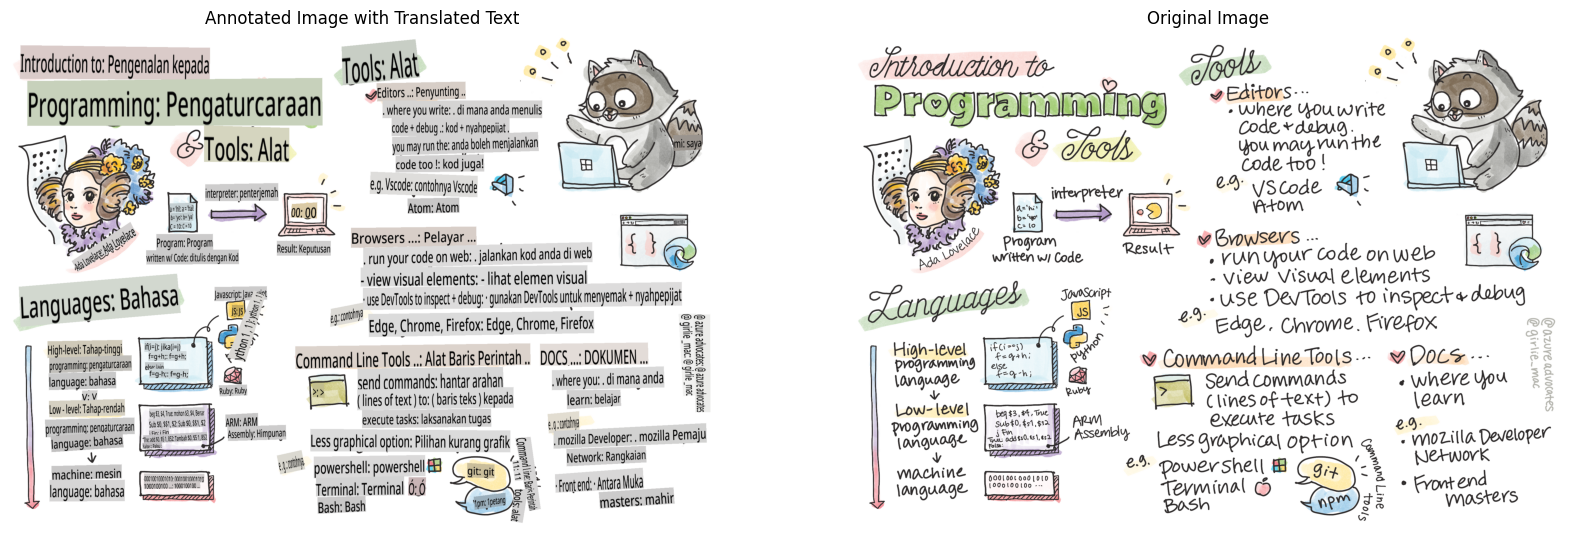

In [25]:
def translate_image(image_path, language):
    plot_annotated_image(image_path, retrieve_bounding_boxes_by_image_path(image_path), get_translated_text_data(image_path, language))
    
translate_image("./images/korean.png", "English")
translate_image("./images/microsoft1.png", "Malay")

